<a href="https://colab.research.google.com/github/jurajgot/self-driving-car/blob/master/robotik3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

Text(0.5, 1.0, 'Preprocessed Image')

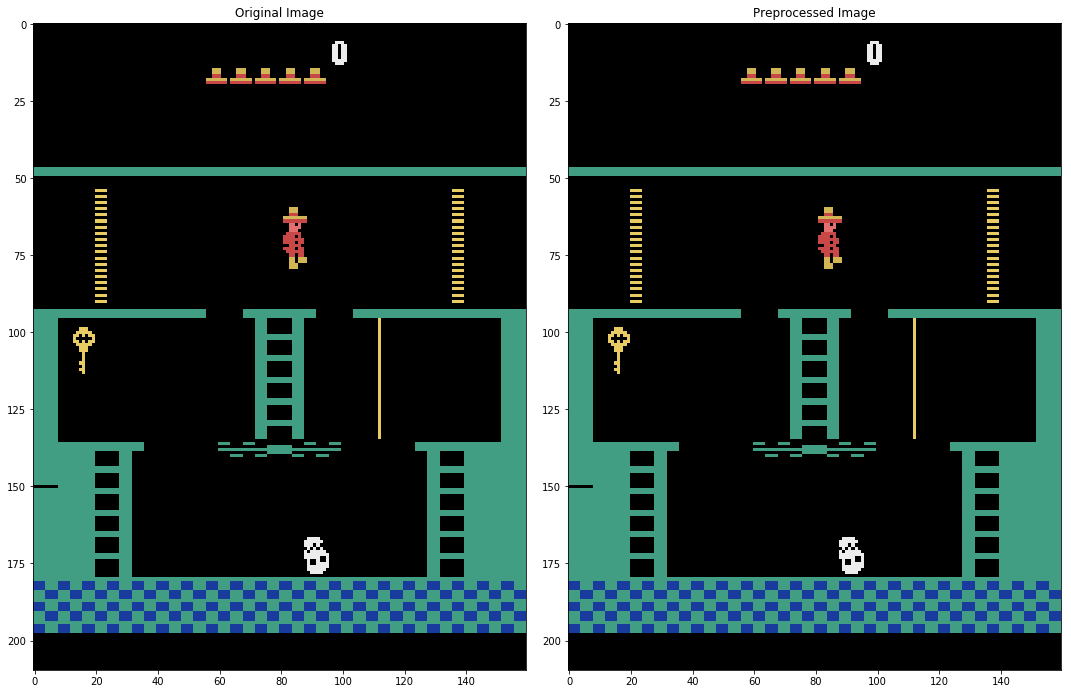

In [7]:
def img_preprocess(image):
  return npimg.imread(image)

## Get any image
image = '/home/jurajgot/atari/montezuma/m1.png'
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [8]:
TRAIN_BUF=1000
BATCH_SIZE=32
DIMS = (210,160,4)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)

In [61]:
train_images = []
for i in range(TRAIN_BUF):
  image = npimg.imread('/home/jurajgot/atari/montezuma/m%d.png' % i)
  train_images += [image]

train_images = np.array(train_images)

In [62]:
train_images = train_images.reshape(train_images.shape[0], DIMS[0], DIMS[1], DIMS[2]).astype(
    "float32"
)

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

In [64]:
import tensorflow_probability as tfp
ds = tfp.distributions

class VAE(tf.keras.Model):
    """a basic vae class for tensorflow
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):

        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [65]:
N_Z = 32
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 10 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 10, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(3, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=7, strides=(5, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(1, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=4, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-3)
# train the model
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

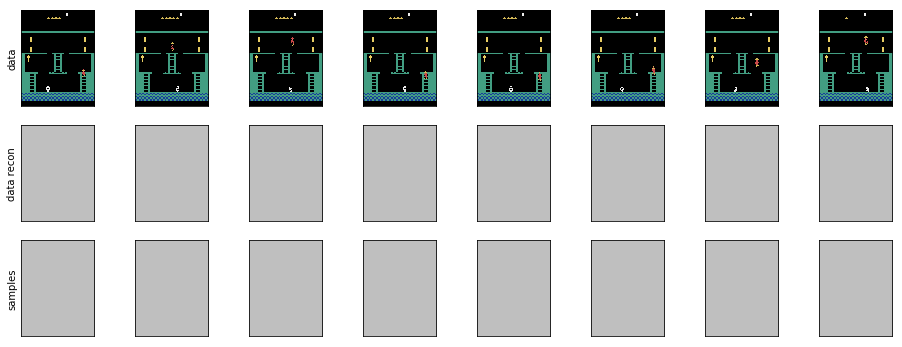

In [66]:
# exampled data for plotting results
example_data = next(iter(train_dataset))

def plot_reconstruction(model, example_data, nex=8, zm=2):
    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            #if axi == 0 and ex == 0:
            #  print(dat.numpy()[ex][108:109])
            image = dat.numpy()[ex]
            #for y in range(210):
            #  for x in range(160):
            #   image[y][x][3] = 0.003
            axs[axi, ex].imshow(image)
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()

plot_reconstruction(model, example_data)


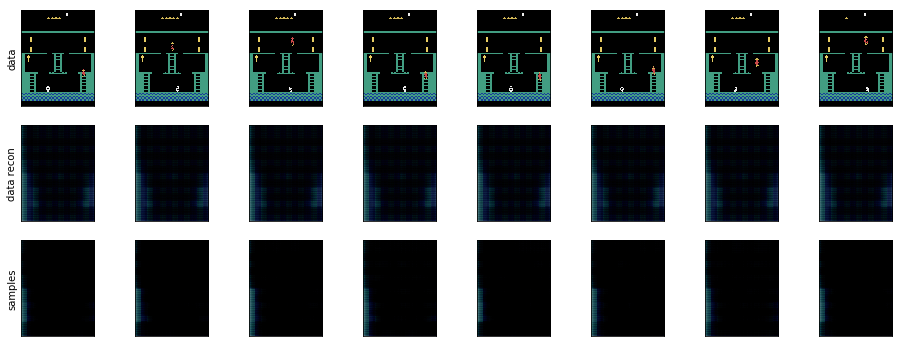

Recon loss 1.2123915, latent loss 0.0205512
Recon loss 1.1973207, latent loss 0.0188871
Recon loss 1.1841427, latent loss 0.0185322


In [ ]:
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

n_epochs = 100
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
        loss = model.compute_loss(train_x)
        print("Recon loss %.7f, latent loss %.7f" % (loss[0], loss[1]))
    clear_output()
    plot_reconstruction(model, example_data)

